In [1]:
from tf_activation.models import mnist_cff as mnist_model
from tf_activation.experiments import distance_finder
from tf_activation.models.mnist_map import mnist_map

from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
persistence_module = tf.load_op_library('/home/tgebhart/python/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

from time import time
import os
from functools import wraps
import errno
import os
import signal

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
SAVE_PATH = '../logdir/models'
model = 'mnist_cff_2000.ckpt'
NUM_STEPS = 5000
p = 99

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = False

In [ ]:
# kmeans = KMeans(init='k-means++', n_clusters=len(mnist.train.labels[0]), n_init=10)
# kmeans = KMeans(init='k-means++', n_clusters=50, n_init=10)
# kmeans.fit(mnist.train.images)
# joblib.dump(kmeans, os.path.join(SAVE_PATH, 'kmeans.pkl'))
kmeans = joblib.load(os.path.join(SAVE_PATH, 'kmeans.pkl'))

In [ ]:
class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator

In [ ]:
@timeout(10)
def per_distance_func(result):
    per_distance = result.eval(feed_dict={x: test_inputs, keep_prob:1.0})
    return per_distance

In [ ]:
df = []
centers = kmeans.cluster_centers_
timeouts = []
with tf.device('/cpu:0'):
        # Create the model
        x = tf.placeholder(tf.float32, [None, 784])

        # Define loss and optimizer
        y_ = tf.placeholder(tf.float32, [None, 10])

        # Build the graph for the deep net
        net, keep_prob = mnist_model.deepnn(x)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver()
        
with tf.Session(config=config) as sess:

    saver.restore(sess, os.path.join(SAVE_PATH, model))

    for i in range(NUM_STEPS):
        col = {}
        s = kmeans.score(mnist.train.images[i].reshape(1,-1))
        c = centers[kmeans.predict(mnist.train.images[i].reshape(1,-1))][0,:]
        center_num = kmeans.predict(mnist.train.images[i].reshape(1,-1))[0]
        d = np.linalg.norm(c - mnist.train.images[i])
        col['score'] = s
        col['distance'] = d
        col['correct'] = np.argmax(mnist.train.labels[i])
        col['center'] = center_num
        print("Center:", center_num)
    
        test_inputs = np.stack((mnist.train.images[i], c))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        percentiles = persistence_module.layerwise_percentile([net['input'],
                                                            net['W_conv1'],
                                                            net['h_conv1'],
                                                            net['h_conv1'],
                                                            net['W_fc1'],
                                                            net['h_fc1'],
                                                            net['h_fc1_drop'],
                                                            net['W_fc2'],
                                                            net['y_conv']],
                                                            [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                            [p,p,p])

        ps1 = percentiles.eval(feed_dict={x: test_inputs[0:1], keep_prob:1.0})
        ps2 = percentiles.eval(feed_dict={x: test_inputs[1:2], keep_prob:1.0})
        
        
        result = persistence_module.wasserstein_distance([net['input'],
                                                            net['W_conv1'],
                                                            net['h_conv1'],
                                                            net['h_conv1'],
                                                            net['W_fc1'],
                                                            net['h_fc1'],
                                                            net['h_fc1_drop'],
                                                            net['W_fc2'],
                                                            net['y_conv']],
                                                            [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                            np.stack((ps1, ps2))
                                                            )
        try:
            per_distance = per_distance_func(result)
        except TimeoutError:
            print('TimeoutError!')
            timeouts.append(i)
            continue
            

        print('Test Image: {}, Persistence Distance: {}'.format(i, per_distance))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['per_distance'] = per_distance[0]
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        
        df.append(col)

In [5]:
# df = pd.read_pickle('../logdir/data/experiments/cluster_mnist/cluster_df.pkl')
temp = np.load('../logdir/data/experiments/cluster_mnist/intermediate_df.pkl')
df = pd.DataFrame(temp)
df.head()

,accuracy,correct,cross_entropy,distance,per_distance,y_conv
0,0.5,7,1.034922,9.818526,133167.906250,0.567066
1,0.5,3,1.417772,9.506930,133147.453125,0.673701
2,0.5,4,1.758312,8.402806,133344.250000,0.617593
3,0.5,6,1.625252,8.140593,133093.718750,0.727593
4,1.0,1,0.246916,5.778604,133004.140625,0.837557


In [6]:
# df.head()
# df['center'].value_counts()

In [24]:
def regress(X, y, xlab, ylab, color_vals='b'):

    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))

    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs

    ax.scatter(X, y,  color=color_vals)
#     ax.plot(X, regr.predict(X), color='silver', linewidth=3)
#     ax.set_xlim(X_min, X_max)
#     ax.set_ylim(y_min, y_max)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('{} vs {}'.format(xlab, ylab))

    plt.show()

In [25]:
df.head(10)

,accuracy,correct,cross_entropy,distance,per_distance,y_conv
0,0.5,7,1.034922,9.818526,133167.906250,0.567066
1,0.5,3,1.417772,9.506930,133147.453125,0.673701
2,0.5,4,1.758312,8.402806,133344.250000,0.617593
3,0.5,6,1.625252,8.140593,133093.718750,0.727593
4,1.0,1,0.246916,5.778604,133004.140625,0.837557
5,0.5,8,2.135958,10.082397,133025.000000,0.710813
6,1.0,1,0.246959,6.913589,133012.609375,0.821202
7,0.5,0,0.801161,10.774114,133006.687500,0.830512
8,0.5,9,1.915361,7.075385,133153.578125,0.778495
9,0.5,8,2.135859,10.121042,133041.343750,0.721241


('Class:', 0)
('Coefficients: ', array([[-0.97116976]]))
Mean squared error: 14.15
Variance score: 0.13
R^2: 0.13


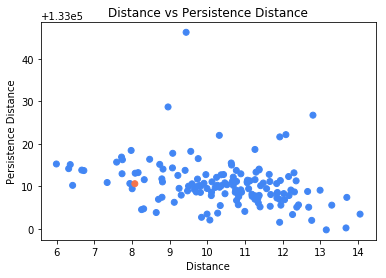

('Class:', 1)
('Coefficients: ', array([[-0.43811474]]))
Mean squared error: 128.47
Variance score: -0.13
R^2: -0.13


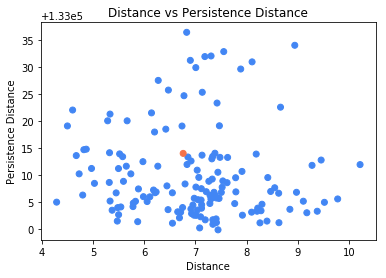

('Class:', 2)
('Coefficients: ', array([[-834.97089649]]))
Mean squared error: 1982439.37
Variance score: -256188.97
R^2: -256188.97


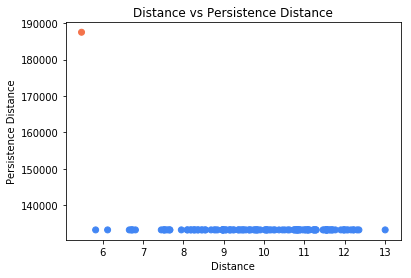

('Class:', 3)
('Coefficients: ', array([[-0.01675091]]))
Mean squared error: 42.37
Variance score: -0.32
R^2: -0.32


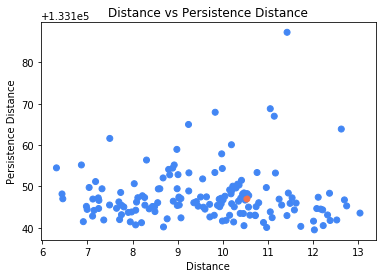

('Class:', 4)
('Coefficients: ', array([[-0.80758542]]))
Mean squared error: 9.50
Variance score: -0.02
R^2: -0.02


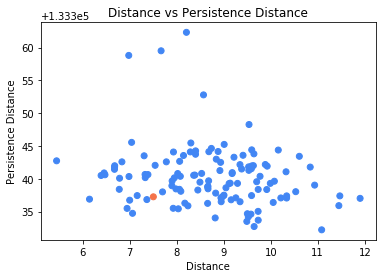

('Class:', 5)
('Coefficients: ', array([[ 256.95627403]]))
Mean squared error: 318807.07
Variance score: -4337.79
R^2: -4337.79


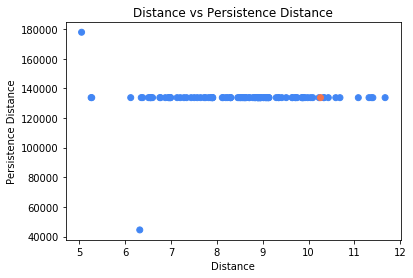

('Class:', 6)
('Coefficients: ', array([[-0.26955537]]))
Mean squared error: 63.77
Variance score: -0.02
R^2: -0.02


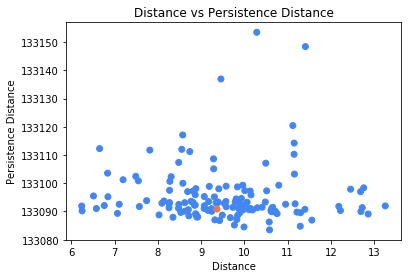

('Class:', 7)
('Coefficients: ', array([[ 142.89128595]]))
Mean squared error: 55988.58
Variance score: -3196.52
R^2: -3196.52


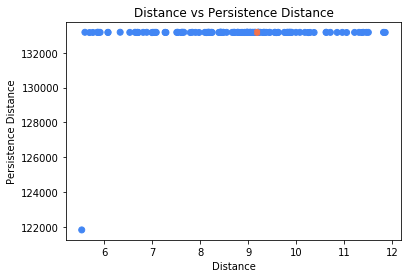

('Class:', 8)
('Coefficients: ', array([[ 0.57871098]]))
Mean squared error: 63.30
Variance score: -0.07
R^2: -0.07


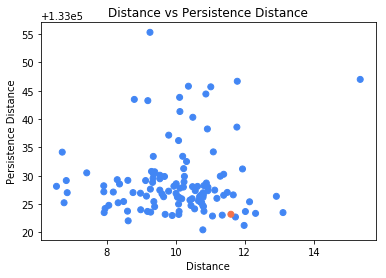

('Class:', 9)
('Coefficients: ', array([[-0.36146407]]))
Mean squared error: 11.00
Variance score: -0.18
R^2: -0.18


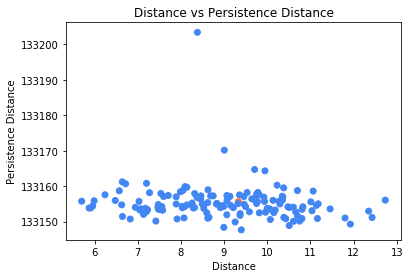

In [35]:
for cls in range(10):
    print('Class:',cls)
    tdf = df[df['correct'] == cls]
    color_vals = ['#f4734b' if acc == 0.0 else '#4286f4' for acc in df['accuracy']]
    regress(tdf.as_matrix(columns=['distance']), tdf.as_matrix(columns=['per_distance']), 'Distance', 'Persistence Distance', color_vals=color_vals)

In [32]:
distances = []
for cls in range(10):
    col = {}
    col['avg_per_distance'] = np.average(df[df['correct'] == cls]['per_distance'])
    col['var_per_distance'] = np.var(df[df['correct'] == cls]['per_distance'])
    col['std_per_distance'] = np.std(df[df['correct'] == cls]['per_distance'])
    col['avg_distance'] = np.average(df[df['correct'] == cls]['distance'])
    distances.append(col)
ddf = pd.DataFrame(distances, index=list(range(10)))

In [33]:
ddf.head(10)

,avg_distance,avg_per_distance,std_per_distance,var_per_distance
0,10.394001,133010.514876,5.464840,2.986447e+01
1,6.953474,133010.016794,8.222986,6.761750e+01
2,9.877607,133600.343392,4728.077151,2.235471e+07
3,9.603457,133147.594968,6.306027,3.976597e+01
4,8.701436,133340.247984,4.575302,2.093338e+01
5,8.547199,133327.220241,9483.530386,8.993735e+07
6,9.522494,133095.469092,10.169162,1.034119e+02
7,8.664955,133085.219605,965.546733,9.322805e+05
8,10.045621,133028.867188,6.220604,3.869592e+01
9,8.980865,133155.243335,5.157312,2.659787e+01


In [34]:
ddf.to_pickle('../logdir/models/distance_stats.pkl')

In [13]:
a_mnist = np.load('../logdir/models/average_mnist.npy')

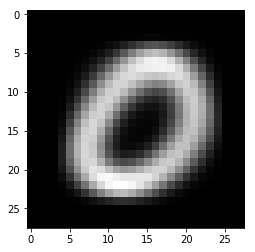

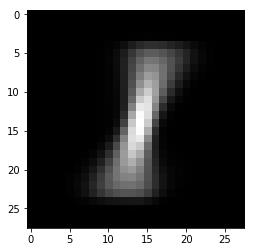

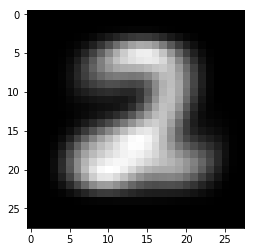

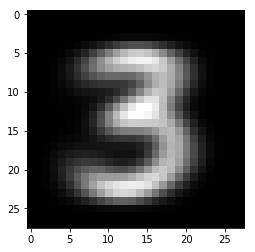

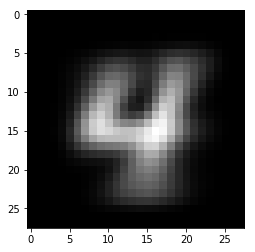

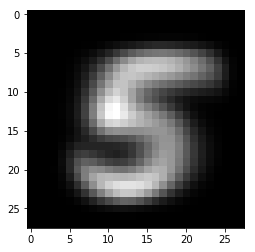

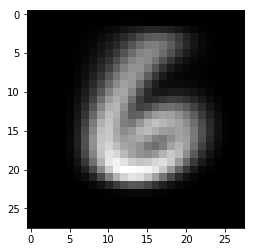

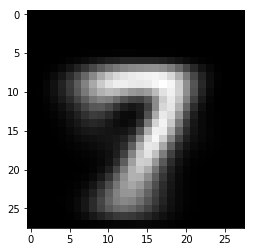

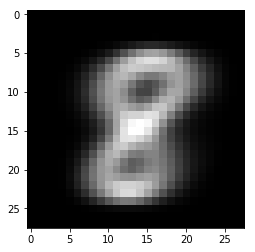

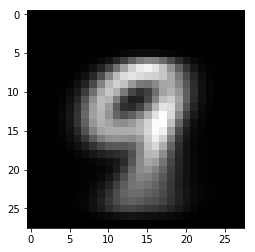

In [14]:
for i in range(10):
    im = a_mnist[:,i]
    plt.imshow(np.reshape(im, [28,28]), interpolation="nearest", cmap="gray")
    plt.show()